# A tour of the ComPert model

In [1]:
import sys
sys.path.append("../")

In [2]:
# some standard packages to assist this tutorial
from pprint import pprint

In [3]:
from compert.train import train_compert
from compert.data import load_dataset_splits
from compert.plotting import CompertVisuals, ComPertHistory
from compert.api import ComPertAPI, get_reference_from_combo
import pandas as pd
import compert.plotting as pl

In [4]:
from os import listdir
from os.path import isfile, join
from os import walk

mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if 'GSM_new' in f:
            print(join(mypath, fold, f))

../pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt


In [5]:
# adata = sc.read("./datasets/GSM_new.h5ad")

# Loading pre-trained model

This part is optional if you want to load pre-trained model. The name of the file where the model was saved appears as the last line of the output the train_compert().

In [6]:
import torch
from compert.train import prepare_compert

model_name = '../pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
args['dataset_path'] = '../datasets/GSM_new.h5ad'

# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state)

# History

In [7]:
from compert.plotting import ComPertHistory
pretty_history = ComPertHistory(history)

In [8]:
pretty_history.print_time()

Computation time: 64 min


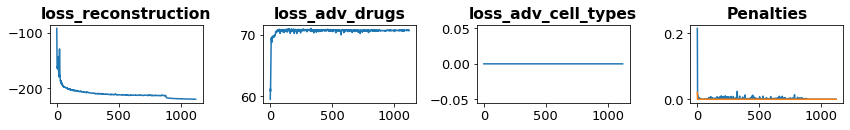

In [9]:
pretty_history.plot_losses()

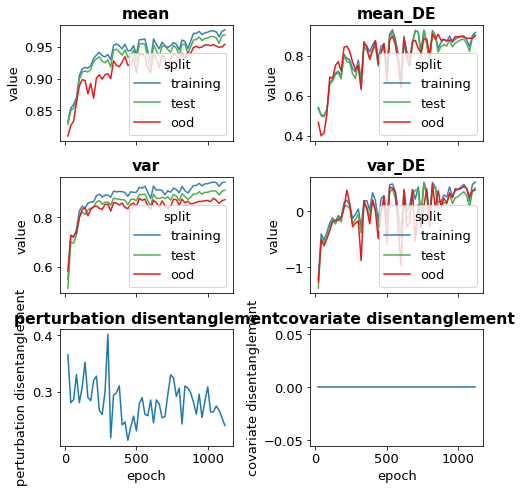

In [10]:
pretty_history.plot_metrics(epoch_min=0)

In [11]:
from compert.train import evaluate

# ComPert API for compatibility with scanpy

In [12]:
compert_api = ComPertAPI(datasets, autoencoder)

In [13]:
compert_api.num_measured_points['training']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

Print and plot drug embeddings.

In [14]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 256
    obs: 'condition'

Print and plot covars embeddings.

In [15]:
covars_anndata = compert_api.get_covars_embeddings()
covars_anndata

AnnData object with n_obs × n_vars = 1 × 256
    obs: 'cell_type'

Setting up a variable for automatic plotting. The plots also could be used separately.

In [16]:
compert_plots = CompertVisuals(compert_api, fileprefix=f"../paper_figures/figure2/{model_name.split('/')[-2]}")

In [17]:
print(compert_api.unique_perts)

['Dex', 'BMS', 'Nutlin', 'Vehicle', 'SAHA']


If your have a lot of cell types or a lot of perturbations, you can also chose to not display their names.

Or I can change the color scheme for the emebddings.

Saved file to: ../paper_figures/figure2/GSM_emebdding.png
Saved file to: ../paper_figures/figure2/GSM_emebdding_similarity.png


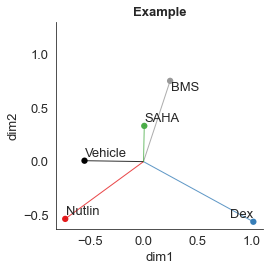

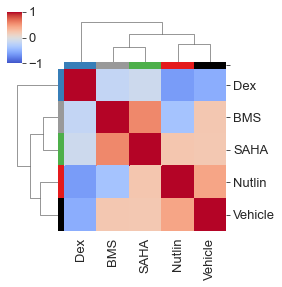

In [18]:
perts_palette = {'BMS': '#999999',                 
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'    
                }

compert_plots.perts_palette = perts_palette
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

Saved file to: ../paper_figures/figure2/GSM_emebdding.png
Saved file to: ../paper_figures/figure2/GSM_emebdding_similarity.png


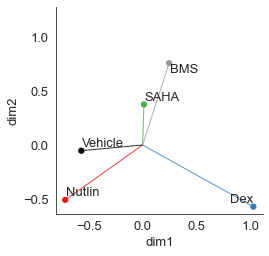

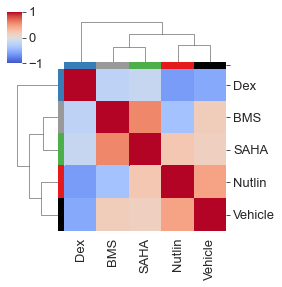

In [19]:
emd_unst = compert_api.emb_perts.copy()
for i in range(len(emd_unst)):
    emd_unst[i] = compert_api.emb_covars[0].copy() + compert_api.emb_perts[i]
compert_plots.plot_latent_embeddings(emd_unst, 
                                     kind='perturbations',
                                     show_text=True, titlename='',
                                     palette=compert_plots.perts_palette)

In [20]:
compert_plots.plot_latent_embeddings(compert_api.emb_covars, kind='covars')

Embedding contains only 1 vectors. Not enough to plot.


In [21]:
latent_response = compert_api.latent_dose_response(perturbations=None)

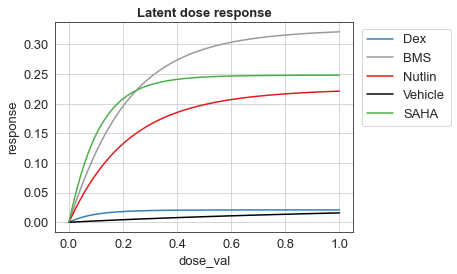

In [22]:
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',    
    var_name=compert_api.perturbation_key,
    title_name='Latent dose response')

In [23]:
compert_api.measured_points['all']['A549']['BMS']

[0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 0.5]

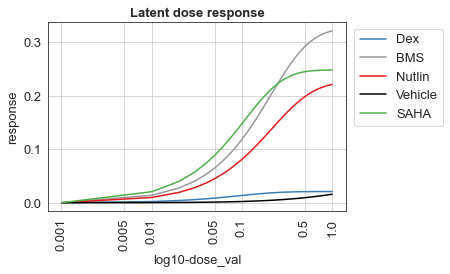

In [24]:
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',    
    var_name=compert_api.perturbation_key,
    logdose=True,
    measured_points=compert_api.measured_points['all']['A549']['BMS'],
    title_name='Latent dose response')

Saved file to: ../paper_figures/figure2/GSM_response2D.png


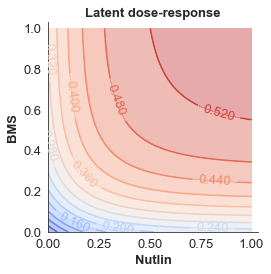

In [25]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = compert_api.latent_dose_response2D(perturbations_pair, n_points=100)
compert_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')


Saved file to: ../paper_figures/figure2/GSM_response2D.png
CPU times: user 30.4 s, sys: 1.24 s, total: 31.6 s
Wall time: 30.9 s


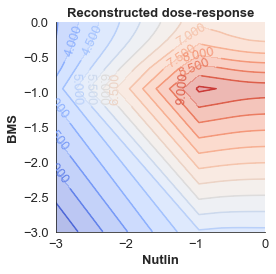

In [26]:
%%time
reconstructed_response2D = compert_api.get_response2D(datasets, perturbations_pair, compert_api.unique_сovars[0])
compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='Reconstructed dose-response', logdose=True, xlims=(-3, 0), ylims=(-3, 0))

If you want to plot in on a log scale, you can just log values in the data frame.

In [27]:
# %%time
df_reference = compert_api.get_response_reference(datasets)        

In [28]:
# %%time
reconstructed_response = compert_api.get_response(datasets)

You can plot an average response (saved under "response" column) among all genes, however, we don't consider it to be a good metric and strongly advise to look at the individual response among DE genes.

Solid lines in this plot correspond to the model predictions, dashed lines -- linear interpolations between measured points. Dots represent measured points, their color is proportional to the number of cells in this condition. Black dots represent points used in training and red dots correspond to the out-of-distribution examples.

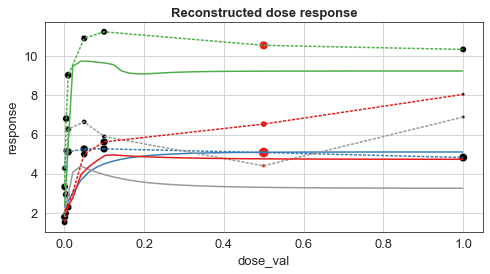

In [29]:
df_reference = df_reference.replace('training_treated', 'train')
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    palette=compert_plots.perts_palette,
    title_name='Reconstructed dose response')

For example we can take of the top 50 DE genes for Nutlin - MDM2. MDM2 is itself transcriptionally-regulated by p53. And p53 is the target of Nutlin. Therefore, we expect our model to learn it.

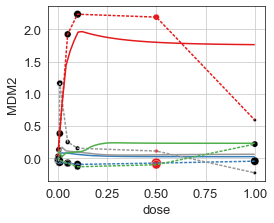

In [30]:
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    figsize=(4, 3.3),
    bbox=(1.6, 1.),
    response_name='MDM2',
    xlabelname='dose',
    logdose=False,
#     measured_points=compert_api.measured_points['all']['A549']['BMS'],
    palette=compert_plots.perts_palette,
    title_name='')

We can also look at this plot on the log10-scale. It makes sense for this dataset, because the measured doses were not evenly distributed.

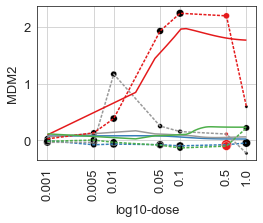

In [31]:
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    figsize=(4, 3.3),
    bbox=(1.6, 1.),
    response_name='MDM2',
    xlabelname='log10-dose',
    logdose=True,
    palette=compert_plots.perts_palette,
    measured_points=compert_api.measured_points['all']['A549']['BMS'],
    title_name='')

# Predictions

In [32]:
print('Perturbations:', compert_api.unique_perts)
print('Covariates:', compert_api.unique_сovars)
print('Datasets splits:', datasets.keys())

Perturbations: ['Dex', 'BMS', 'Nutlin', 'Vehicle', 'SAHA']
Covariates: ['A549']
Datasets splits: dict_keys(['training', 'training_control', 'training_treated', 'test', 'test_control', 'test_treated', 'ood'])


# Evaluation

In [33]:
genes_control = datasets['training_control'].genes
df_train = compert_api.evaluate_r2(datasets['training_treated'], genes_control)
df_train['benchmark'] = 'CPA'

In [34]:
genes_control = datasets['test_control'].genes
df_ood = compert_api.evaluate_r2(datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'

In [35]:
genes_control = datasets['test_control'].genes
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [36]:
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [37]:
df_ood['split'] = 'ood'
df_test['split'] ='test'
df_train['split'] ='train'

In [38]:
df_score = pd.concat([df_test, df_ood])
df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split
20,A549,SAHA,0.01,0.99,0.99,0.95,0.86,160,CPA,test
19,A549,SAHA,0.005,0.98,0.98,0.93,0.88,143,CPA,test
21,A549,SAHA,0.05,0.98,0.95,0.93,0.83,118,CPA,test
23,A549,SAHA,1.0,0.98,0.95,0.91,0.64,137,CPA,test
18,A549,SAHA,0.001,0.97,0.97,0.92,0.48,169,CPA,test
22,A549,SAHA,0.1,0.96,0.86,0.94,0.86,129,CPA,test
3,A549,SAHA,0.5,0.96,0.86,0.89,0.31,604,CPA,ood
12,A549,Nutlin,0.001,0.98,0.98,0.94,0.88,135,CPA,test
15,A549,Nutlin,0.05,0.98,0.98,0.94,0.89,136,CPA,test
13,A549,Nutlin,0.005,0.98,0.97,0.94,0.80,107,CPA,test


In [39]:
# cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'R2_var_DE', 'split', 'num_cells']
# df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)
# print(df_score[cols_print])
# # print(df_score[cols_print].to_latex(index=False))

cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'split', 'num_cells']
df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE', 'R2_var'], ascending=False)
df_latex = df_score[cols_print].copy()
df_latex = df_latex.replace('ood', '\textbf{ood}')
print(df_latex.to_latex(index=False, bold_rows=True, escape=False))

\begin{tabular}{llrrrlr}
\toprule
condition & dose_val &  R2_mean &  R2_mean_DE &  R2_var &        split &  num_cells \\
\midrule
     SAHA &     0.01 &     0.99 &        0.99 &    0.95 &         test &        160 \\
     SAHA &    0.005 &     0.98 &        0.98 &    0.93 &         test &        143 \\
     SAHA &     0.05 &     0.98 &        0.95 &    0.93 &         test &        118 \\
     SAHA &      1.0 &     0.98 &        0.95 &    0.91 &         test &        137 \\
     SAHA &    0.001 &     0.97 &        0.97 &    0.92 &         test &        169 \\
     SAHA &      0.1 &     0.96 &        0.86 &    0.94 &         test &        129 \\
     SAHA &      0.5 &     0.96 &        0.86 &    0.89 & \textbf{ood} &        604 \\
   Nutlin &    0.001 &     0.98 &        0.98 &    0.94 &         test &        135 \\
   Nutlin &     0.05 &     0.98 &        0.98 &    0.94 &         test &        136 \\
   Nutlin &    0.005 &     0.98 &        0.97 &    0.94 &         test &        107 \\


# Uncertainty

We can profile all the predictions with an uncertainty score. Low uncertainty means "good/trustworthy" predictions, high values mean "bad/unknown quality" predictions.

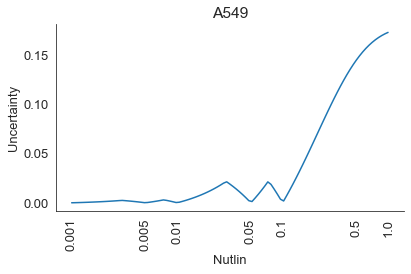

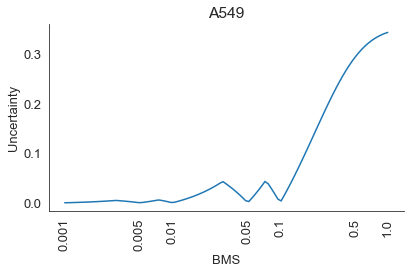

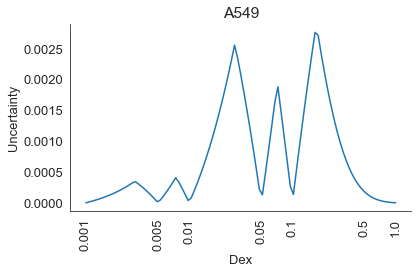

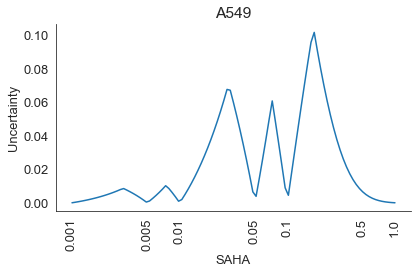

In [58]:
import compert.plotting as pl

uncert_list = []
for i, drug in enumerate(['Nutlin', 'BMS', 'Dex', 'SAHA']):
    uncert_list.append(pl.plot_uncertainty_dose(
        compert_api,
        cov='A549',
        pert=drug,
        N=101,
        measured_points=compert_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='eucl',
        filename=f'{compert_plots.fileprefix}_uncertainty_{drug}.png',
    ))
df_uncert = pd.concat(uncert_list)


In [59]:
import numpy as np

df_ref = get_reference_from_combo(['Nutlin'], datasets)
df_ref['uncertainty_cosine'] = 0
df_ref['uncertainty_eucl'] = 0
df_ref['condition'] = 'Nutlin'
df_ref
df_ref['log10-dose'] = [np.log10(float(d)) for d in df_ref['Nutlin'].values]

Nutlin 0.001 284
Nutlin 0.005 252
Nutlin 0.01 387
Nutlin 0.05 350
Nutlin 0.1 457
Nutlin 1.0 6
Nutlin 0.5 265


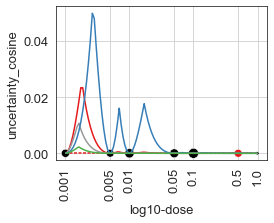

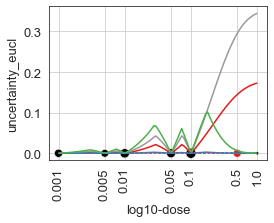

In [60]:
import numpy as np
df_uncert['log10-dose'] = [np.log10(float(d)) for d in df_uncert['dose_val'].values]
for unc in ['uncertainty_cosine', 'uncertainty_eucl']:
    pl.plot_dose_response(df_uncert,
                               'log10-dose',
                               'condition',
                               xlabelname='log10-dose',
                               df_ref=df_ref,
                               response_name=unc,
                               title_name='',
                               use_ref_response=True,
                               col_dict=perts_palette,
                               plot_vertical=False,
#                                f1=6,
                               f1=4,
                               f2=3.3,
                               logscale=compert_api.measured_points['all']['A549']['BMS'],
                               fname=f'../paper_figures/figure2/GSM_{unc}',
#                                bbox=(1.5, 1.),
                               bbox=(1.6, 1.),
                               fontsize=13,
                               format='png')


We can check how certain is the model about our OOD predictions.

In [43]:
import pandas as pd
import numpy as np
uncertainty = pd.DataFrame(columns=[compert_api.covars_key, 
                                        compert_api.perturbation_key, 
                                        compert_api.dose_key, 'cosine', 'euclidean', 'split'])

i = 0
for split in ['ood']:
    for pert in compert_api.seen_covars_perts[split]:
        cov, drug, dose = pert.split('_')
        uncert_cos, uncert_eucl, closest_point_cos, closest_point_eucl = compert_api.compute_uncertainty(cov, drug, dose)
        print(pert, closest_point_cos, closest_point_eucl)
        uncertainty.loc[i] = [cov, drug, dose, uncert_cos, uncert_eucl, split]
        i+= 1

A549_BMS_0.5 A549_BMS_0.1 A549_BMS_0.1
A549_Dex_0.5 A549_Dex_1.0 A549_Dex_1.0
A549_Nutlin_0.5 A549_Nutlin_0.1 A549_Nutlin_0.1
A549_SAHA_0.5 A549_SAHA_1.0 A549_SAHA_1.0


In [44]:
check_ucertainty = uncertainty.merge(df_ood,
                                how="left",
                                on=[compert_api.covars_key,
                                     compert_api.perturbation_key,
                                     compert_api.dose_key])

Saved file to: ../paper_figures/figure2/GSM_scatter.png
Saved file to: ../paper_figures/figure2/GSM_scatter_euclidean.png


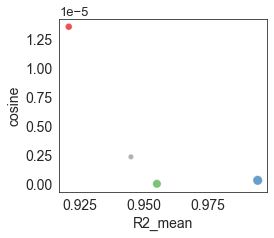

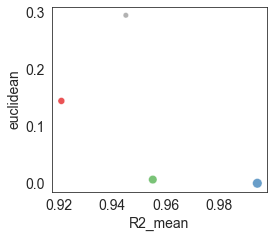

In [56]:
compert_plots.plot_scatter(check_ucertainty, 
         'R2_mean', 
         'cosine',
         hue='condition',
         figsize=(4,3.5),
         style='split_x',
         palette= compert_plots.perts_palette,                 
#          postfix='_1-R2_100cells',
         size='num_cells')

compert_plots.plot_scatter(check_ucertainty, 
         'R2_mean', 
         'euclidean',
         hue='condition',
         figsize=(4,3.5),
         style='split_x',
         palette= compert_plots.perts_palette,                 
         postfix='_euclidean',
         size='num_cells')

Previously, we demonstrated CPA predictions for drugs combinations. But our training data didn't contain any combinations examples. How much can we trust these examples? We can try to asses by running model uncertainty predictions:

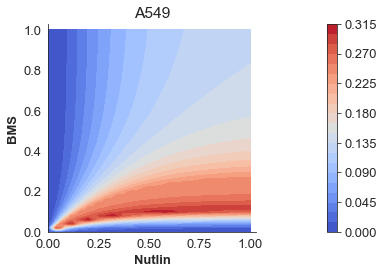

In [46]:
df_pred = pl.plot_uncertainty_comb_dose(
    compert_api=compert_api,
    cov='A549',
    pert='Nutlin+BMS',
    N=51,
    cond_key='treatment',
    filename=f'{compert_plots.fileprefix}_uncertainty_Nutlin_BMS.png',
    metric='cosine',
)

And here is the predicted response we plotted before:

Saved file to: ../paper_figures/figure2/GSM_Nutlin_BMS_MDM2response2D.png


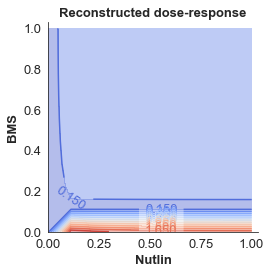

In [47]:
compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    response_name='MDM2',
    postfix='Nutlin_BMS_MDM2',
    title_name='Reconstructed dose-response', logdose=False)

In [48]:
datasets['training'].de_genes['A549_BMS_0.1']

array(['S100A6', 'POLR2L', 'S100A4', 'KRT81', 'PDE10A', 'PDE4D', 'FTL',
       'S100A11', 'ALDH3A1', 'TUBA1B', 'TXN', 'GAPDH', 'MIR31HG', 'TFPI2',
       'CYP24A1', 'GCLC', 'TNS3', 'AC016205.1', 'ID3', 'CSGALNACT1',
       'RPS13', 'RPL3L', 'THSD7A', 'GPX2', 'CACNA2D1', 'NRIP1', 'GPRIN3',
       'GRAMD1B', 'NCOA2', 'FGA', 'ASPM', 'AC008050.1', 'MAP7', 'UBC',
       'BMPR1B', 'TMCC1', 'EVA1C', 'RAD18', 'PFN1', 'HSPA1A', 'ZFPM2-AS1',
       'COL4A4', 'ST6GAL2', 'LINC01572', 'KRT86', 'TK1', 'LINC00511',
       'DUSP16', 'MEGF9', 'ZRANB3'], dtype=object)

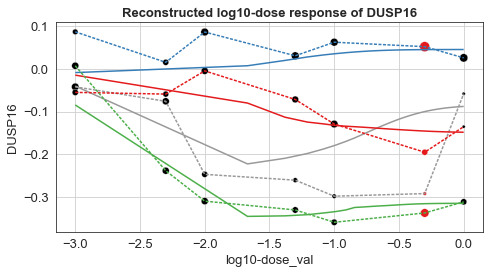

In [49]:
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='DUSP16',
    postfix='DUSP16_log',
    logdose=True,
    title_name='Reconstructed log10-dose response of DUSP16')

Saved file to: ../paper_figures/figure2/GSM_Nutlin_BMS_DUSP16response2D.png


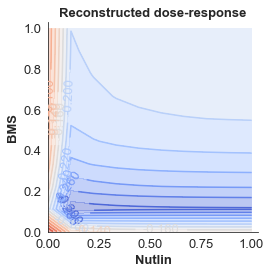

In [50]:
compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    response_name='DUSP16',
    postfix='Nutlin_BMS_DUSP16',
    title_name='Reconstructed dose-response', logdose=False)

And now keep in mind, that the highest uncertainty for OOD cases (for which we know that their predictions were fairly good) is 0.07:

In [51]:
check_ucertainty['euclidean'].max().round(2)

0.3

Therefore, be careful with interpreting drug combinations in this dataset!

# Basic Benchmarks

In [52]:
from compert.api import evaluate_r2_benchmark
df_benchmarks = []
for drug in np.unique(df_ood['condition'].values):
    benchmarks = []
    benchmarks.append(f'A549_{drug}_0.1+A549_{drug}_1.0')
    df_benchmarks.append(evaluate_r2_benchmark(compert_api, datasets, f'A549_{drug}_0.5', benchmarks))

In [53]:
df_ood['method'] = 'CPA'
df_bench = pd.concat([df_ood] + df_benchmarks)

In [54]:
df_bench = df_bench.replace('benchmark', 'linear')
cols_print = ['condition', 'R2_mean', 'R2_mean_DE', 'method']
df_bench = df_bench[cols_print].sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False).round(2)
df_bench

,condition,R2_mean,R2_mean_DE,method
0,SAHA,0.98,0.94,linear
3,SAHA,0.96,0.86,CPA
2,Nutlin,0.92,0.86,CPA
0,Nutlin,0.85,0.80,linear
0,Dex,1.00,1.00,linear
1,Dex,0.99,0.99,CPA
0,BMS,0.95,0.89,CPA
0,BMS,0.89,0.85,linear


In [55]:
print(df_bench.to_latex(index=False, bold_rows=True, escape=False))

\begin{tabular}{lrrl}
\toprule
condition &  R2_mean &  R2_mean_DE & method \\
\midrule
     SAHA &     0.98 &        0.94 & linear \\
     SAHA &     0.96 &        0.86 &    CPA \\
   Nutlin &     0.92 &        0.86 &    CPA \\
   Nutlin &     0.85 &        0.80 & linear \\
      Dex &     1.00 &        1.00 & linear \\
      Dex &     0.99 &        0.99 &    CPA \\
      BMS &     0.95 &        0.89 &    CPA \\
      BMS &     0.89 &        0.85 & linear \\
\bottomrule
\end{tabular}

